In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("ALS") \
    .getOrCreate()

In [3]:
movies_schema = StructType([
  StructField('movieId', IntegerType()),
  StructField('title', StringType()),
  StructField('genres', StringType())
])

ratings_schema = StructType([
  StructField('userId', IntegerType()),
  StructField('movieId', IntegerType()),
  StructField('rating', FloatType()),
  StructField('timestamp', IntegerType())  
])

In [4]:
file_location = "./movies.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_movies = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(movies_schema) \
  .load(file_location)

df_movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [5]:
file_location = "./ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df_ratings = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(ratings_schema) \
  .load(file_location)

df_ratings.show()


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    653|   3.0|1094785691|
|     1|    919|   3.5|1094785621|
+------+-------+------+----------+
only showing top 20 rows



In [6]:
(df_ratings_70, df_ratings_30) = df_ratings.randomSplit([0.7, 0.3], 50)
df_ratings_train = df_ratings_70.cache()
df_ratings_test = df_ratings_30.cache()

In [7]:
Maxiter = 10
rank = 10
regparams = 0.1

als = ALS().setMaxIter(Maxiter) \
    .setRegParam(regparams) \
    .setRank(rank) \
    .setUserCol('userId') \
    .setItemCol('movieId') \
    .setRatingCol('rating')


In [8]:
model = als.fit(df_ratings_train)

24/01/29 16:59:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/29 16:59:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [9]:
df_predicted_ratings = model.transform(df_ratings_test)
df_predicted_ratings = df_predicted_ratings.filter(df_predicted_ratings.prediction != float('nan'))

regr_eval = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')
error = regr_eval.evaluate(df_predicted_ratings)
print(f'RMSE Error: {error}')

RMSE Error: 0.805246374624617


In [10]:
Maxiter = [x*2 for x in range(1, 11)]

result_maxiter = []

for i in Maxiter:
    als = ALS().setMaxIter(i) \
    .setRegParam(0.1) \
    .setRank(10) \
    .setUserCol('userId') \
    .setItemCol('movieId') \
    .setRatingCol('rating')
    model = als.fit(df_ratings_train)
    df_predicted_ratings = model.transform(df_ratings_test)
    df_predicted_ratings = df_predicted_ratings.filter(df_predicted_ratings.prediction != float('nan'))

    regr_eval = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')
    error = regr_eval.evaluate(df_predicted_ratings)
    result_maxiter.append(error)

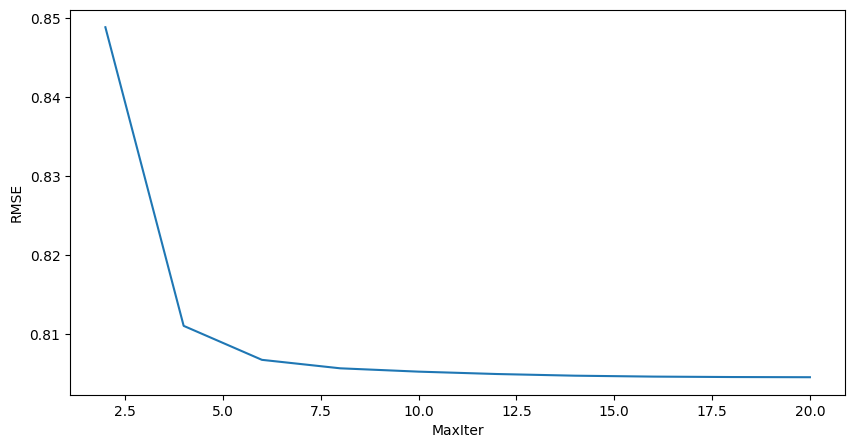

In [11]:
ay = plt.figure(figsize = (10,5)).subplots()
chart = ay.plot(Maxiter, result_maxiter)
ay.set_xlabel('MaxIter')
ay.set_ylabel('RMSE')
plt.show()

In [12]:
rank = [x*2 for x in range(1, 11)]

result_rank = []

for i in Maxiter:
    als = ALS().setMaxIter(10) \
    .setRegParam(0.1) \
    .setRank(i) \
    .setUserCol('userId') \
    .setItemCol('movieId') \
    .setRatingCol('rating')
    model = als.fit(df_ratings_train)
    df_predicted_ratings = model.transform(df_ratings_test)
    df_predicted_ratings = df_predicted_ratings.filter(df_predicted_ratings.prediction != float('nan'))

    regr_eval = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')
    error = regr_eval.evaluate(df_predicted_ratings)
    result_rank.append(error)

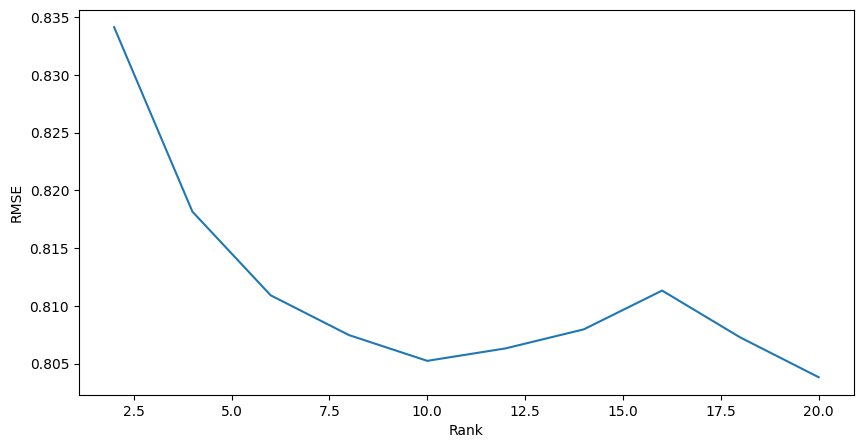

In [13]:
ay = plt.figure(figsize = (10,5)).subplots()
chart = ay.plot(rank, result_rank)
ay.set_xlabel('Rank')
ay.set_ylabel('RMSE')
plt.show()

In [14]:
regparams = [float(x*2 / 100) for x in range(1, 11)]

result_reg = []

for i in Maxiter:
    als = ALS().setMaxIter(10) \
    .setRegParam(i) \
    .setRank(10) \
    .setUserCol('userId') \
    .setItemCol('movieId') \
    .setRatingCol('rating')
    model = als.fit(df_ratings_train)
    df_predicted_ratings = model.transform(df_ratings_test)
    df_predicted_ratings = df_predicted_ratings.filter(df_predicted_ratings.prediction != float('nan'))

    regr_eval = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')
    error = regr_eval.evaluate(df_predicted_ratings)
    result_reg.append(error)

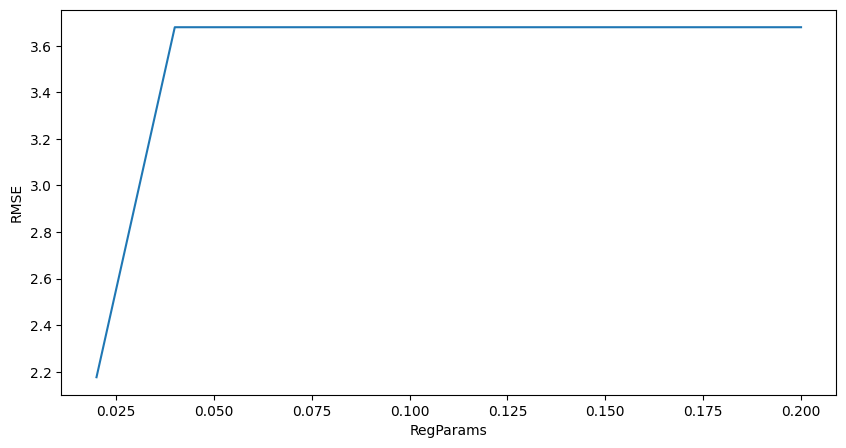

In [15]:
ay = plt.figure(figsize = (10,5)).subplots()
chart = ay.plot(regparams, result_reg)
ay.set_xlabel('RegParams')
ay.set_ylabel('RMSE')
plt.show()

In [19]:
my_user_id = 0

my_rated_movies = [
    (my_user_id, 318, 3, 0), # Shawshank redemption
    (my_user_id, 908, 4, 0), # North by Northwest (1959)
    (my_user_id, 858, 5, 0), # Godfather, The (1972)
    (my_user_id, 2019, 4, 0), # Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)
    (my_user_id, 912, 4, 0), # Casablanca (1942)
    (my_user_id, 1250, 5, 0), # Bridge on the River Kwai, The (1957)
    (my_user_id, 2324, 5, 0), # Life Is Beautiful (La Vita ? bella) (1997)
    (my_user_id, 1233, 5, 0), # Boat, The (Das Boot) (1981)
    (my_user_id, 593, 4, 0), # Silence of the Lambs, The (1991)
    (my_user_id, 1262, 4, 0), # Great Escape, The (1963)
    (my_user_id, 260, 5, 0), # Star Wars: Episode IV - A New Hope (1977) 
     # The format of each line is (my_user_id, movie ID, your rating)
     # For example, to give the movie "Star Wars: Episode IV - A New Hope (1977)" a five rating, you would add the following line:
     #   (my_user_id, 260, 5),
]

In [20]:
df_my_ratings = spark.createDataFrame(my_rated_movies, ['userId', 'movieId', 'rating', 'timestamp'])
df_my_ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|    318|     3|        0|
|     0|    908|     4|        0|
|     0|    858|     5|        0|
|     0|   2019|     4|        0|
|     0|    912|     4|        0|
|     0|   1250|     5|        0|
|     0|   2324|     5|        0|
|     0|   1233|     5|        0|
|     0|    593|     4|        0|
|     0|   1262|     4|        0|
|     0|    260|     5|        0|
+------+-------+------+---------+



In [21]:
print(df_ratings_train.count())
df_training_with_my_own = df_ratings_train.unionAll(df_my_ratings)
print(df_training_with_my_own.count())

13999371
13999382


In [28]:
als = ALS().setMaxIter(10).setRegParam(0.1) \
  .setUserCol('userId') \
  .setItemCol('movieId') \
  .setRatingCol('rating') \
  .setRank(10)

my_model = als.fit(df_training_with_my_own)

In [29]:
my_ratings_movie_ids = [x[1] for x in my_rated_movies]
print(my_ratings_movie_ids)

[318, 908, 858, 2019, 912, 1250, 2324, 1233, 593, 1262, 260]


In [30]:
print(df_movies.count())
df_not_rated = df_movies.filter(~df_movies['movieId'].isin(my_ratings_movie_ids))
print(df_not_rated.count())

27278
27267


In [31]:
from pyspark.sql.functions import lit

df_my_unrated_movies = df_not_rated.withColumn('userId', lit(my_user_id))
df_my_unrated_movies.show()

+-------+--------------------+--------------------+------+
|movieId|               title|              genres|userId|
+-------+--------------------+--------------------+------+
|      1|    Toy Story (1995)|Adventure|Animati...|     0|
|      2|      Jumanji (1995)|Adventure|Childre...|     0|
|      3|Grumpier Old Men ...|      Comedy|Romance|     0|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|     0|
|      5|Father of the Bri...|              Comedy|     0|
|      6|         Heat (1995)|Action|Crime|Thri...|     0|
|      7|      Sabrina (1995)|      Comedy|Romance|     0|
|      8| Tom and Huck (1995)|  Adventure|Children|     0|
|      9| Sudden Death (1995)|              Action|     0|
|     10|    GoldenEye (1995)|Action|Adventure|...|     0|
|     11|American Presiden...|Comedy|Drama|Romance|     0|
|     12|Dracula: Dead and...|       Comedy|Horror|     0|
|     13|        Balto (1995)|Adventure|Animati...|     0|
|     14|        Nixon (1995)|               Drama|     

In [32]:
df_my_predicted_ratings = my_model.transform(df_my_unrated_movies)
df_my_predicted_ratings.show()

+-------+--------------------+--------------------+------+----------+
|movieId|               title|              genres|userId|prediction|
+-------+--------------------+--------------------+------+----------+
|     12|Dracula: Dead and...|       Comedy|Horror|     0|  1.998664|
|      1|    Toy Story (1995)|Adventure|Animati...|     0| 3.8754542|
|     13|        Balto (1995)|Adventure|Animati...|     0| 2.8015845|
|      6|         Heat (1995)|Action|Crime|Thri...|     0|  3.769874|
|     16|       Casino (1995)|         Crime|Drama|     0| 3.7198157|
|      3|Grumpier Old Men ...|      Comedy|Romance|     0| 2.7045376|
|     20|  Money Train (1995)|Action|Comedy|Cri...|     0| 2.2997339|
|      5|Father of the Bri...|              Comedy|     0|  2.436352|
|     19|Ace Ventura: When...|              Comedy|     0|  2.109454|
|     15|Cutthroat Island ...|Action|Adventure|...|     0|  2.160446|
|      9| Sudden Death (1995)|              Action|     0|  2.319711|
|     17|Sense and S

In [33]:
from pyspark.sql.functions import desc

df_my_predicted_ratings = df_my_predicted_ratings.filter(df_my_predicted_ratings.prediction != float('nan'))
df_my_predicted_ratings.sort(desc('prediction')).show(20)

+-------+--------------------+--------------------+------+----------+
|movieId|               title|              genres|userId|prediction|
+-------+--------------------+--------------------+------+----------+
| 120815|Patton Oswalt: We...|              Comedy|     0| 5.3695345|
|  82055|Devil to Pay!, Th...|      Comedy|Romance|     0| 5.3443875|
| 120811|Patton Oswalt: Fi...|              Comedy|     0| 5.2623854|
|  81117|Moth, The (Cma) (...|               Drama|     0| 5.2608485|
| 112473|Stuart: A Life Ba...|               Drama|     0|  5.032073|
|  81072|   Konopielka (1982)|              Comedy|     0|  5.012461|
| 126219|    Marihuana (1936)|   Documentary|Drama|     0|  5.006997|
| 130347|Bill Hicks: Sane ...|              Comedy|     0|  4.960701|
| 112577|Willie & Phil (1980)|Comedy|Drama|Romance|     0| 4.9450665|
| 104119|Forsyte Saga, The...|               Drama|     0| 4.9450665|
| 112423|I Belong (Som du ...|               Drama|     0|  4.928131|
| 120134|Doggiewoggi